# Classification Project: 

The purpose of this project is to find out which customers will make a deposit in bank.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder, OrdinalEncoder, LabelBinarizer
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import optuna


In [166]:
sns.set_style('whitegrid')
sns.set_palette("flare")

# Data cleaning and preparation

- inspect n/a and fill n/a with median and mode
- inspect outliers and drop them using Tukey method

In [167]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head(1)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [169]:
# Variable that have n/a and their amount
df.isnull().sum().to_frame(name='counts').query('counts > 0')

,counts
balance,25


In [170]:
# Missings in variables job and education
print(df['job'].value_counts())
print(df['education'].value_counts())

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64


In [171]:
#  transform balance into float
df['balance'] = df['balance'].str.replace('$', '')
df['balance'] = df['balance'].str.replace(',', '.')
df['balance'] = df['balance'].str.replace(' ', '')
df['balance'] = df['balance'].astype('float')
display(pd.DataFrame(df['balance'].describe()).transpose())

,count,mean,std,min,25%,50%,75%,max
balance,11137.0,1529.129029,3228.114892,-6847.0,123.0,550.0,1708.0,81204.0


In [172]:
# fill in n/a in balance with median value
df['balance'].fillna(df['balance'].median(), inplace= True) 
display(pd.DataFrame(df['balance'].describe()).transpose())

,count,mean,std,min,25%,50%,75%,max
balance,11162.0,1526.936033,3224.829691,-6847.0,123.0,550.0,1699.0,81204.0


In [173]:
# fill in unknown in job and education with mode values
df['job'].replace('unknown', df['job'].mode()[0], inplace= True) 
df['education'].replace('unknown', df['education'].mode()[0], inplace= True) 

''

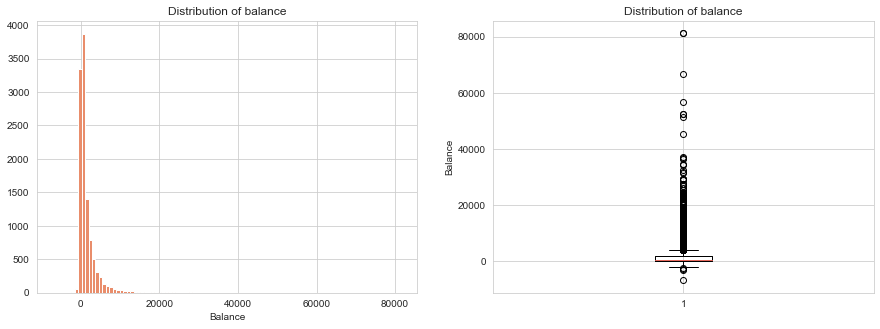

In [174]:
fig = plt.figure(figsize =(15, 5))
plt.subplot(1, 2, 1)
plt.hist(df["balance"], bins= 100)
plt.title("Distribution of balance")
plt.ticklabel_format(style='plain')
plt.xlabel("Balance")
plt.subplot(1, 2, 2)
plt.boxplot(df["balance"])
plt.title("Distribution of balance")
plt.ylabel("Balance")
;


In [175]:
# Drop outliers using Tukey metho
q1,q3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75)
iqr =q3 - q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr

print(f'Lower bound: {lower_bound} \nUpper bound {upper_bound}')

df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
print('Data shape after dropping outliers: ',  df.shape)

Lower bound: -2241.0 
Upper bound 4063.0
Data shape after dropping outliers:  (10105, 17)


# EDA

## Balance check

deposit
no     5424
yes    4681
Name: balance, dtype: int64

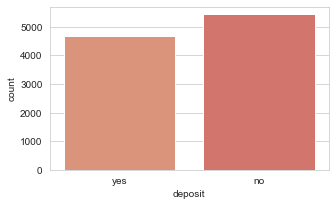

In [176]:
fig = plt.figure(figsize=(5, 3))
ax = sns.countplot(x='deposit', data=df)
df.groupby(['deposit'])['balance'].agg('count')

In terms of target variable the dataset is balanced. 

## Descriptive statistics of continuous variables

In [177]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


- Clients are on average 41 years old, with maximum age 95 and minimum - 18. More than 75% of the clients are younger than 50 years. 
- Average balance is roughly 800, with quite large standard deviation if 1000; the outliers have already been removed, therefore interpretation of min /max values could be misleading. 
- On average, communication with a client lasts 368 seconds (6 mins), with minimum of 2 seconds and maximum of 3881 seconds. The mean is much greater than the median, thus the distribution of contact duration is rather skewed. 
- The mean number of contacts during the campaign is 2.5, every client has been contacted at least once, at max 43 times.
- Before the current campaign, a client was contacted on average 0.8 times, with 0 minimum and 58 times maximum.

## Info and descriptives of categorical variables

In [178]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


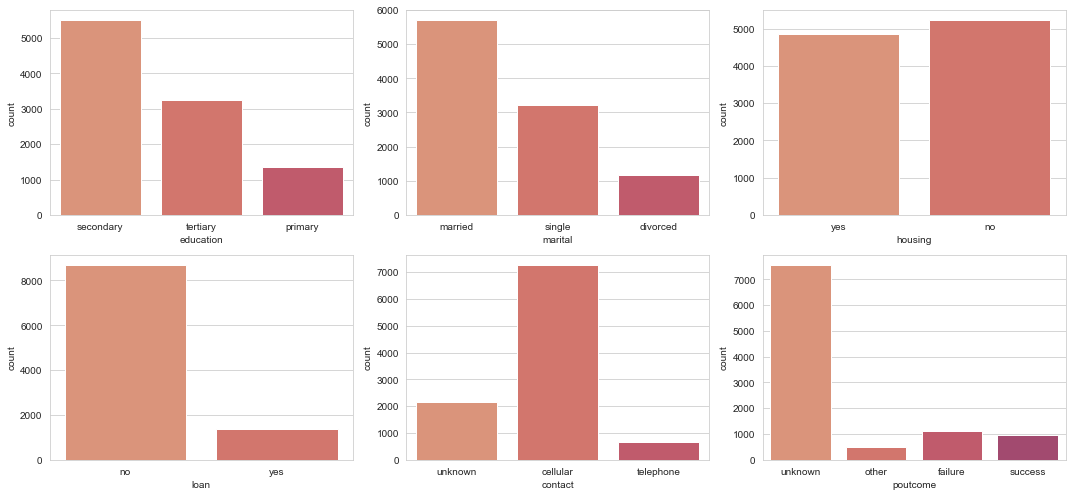

In [179]:
fig ,ax = plt.subplots(2, 3, figsize =(15, 7) )

sns.countplot(x='education', data=df, ax=ax[0,0])
sns.countplot(x='marital', data=df, ax=ax[0,1])
sns.countplot(x='housing', data=df, ax=ax[0,2])
sns.countplot(x='loan', data=df, ax=ax[1,0])
sns.countplot(x='contact', data=df, ax=ax[1,1])
sns.countplot(x='poutcome', data=df, ax=ax[1,2])
plt.tight_layout()

<AxesSubplot:xlabel='job', ylabel='count'>

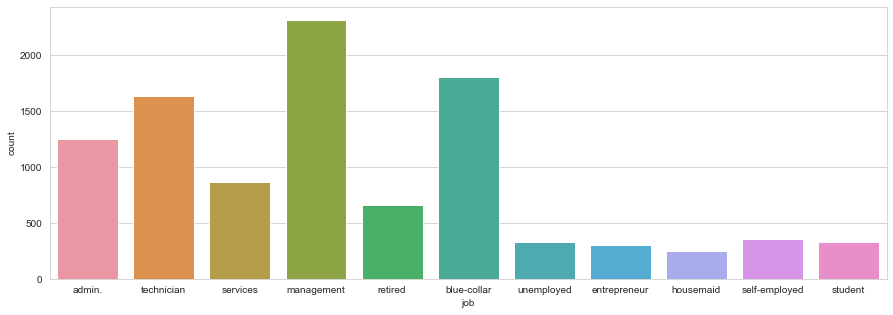

In [180]:
fig = plt.figure(figsize =(15, 5))
sns.countplot(x='job', data=df)

An average client is a married manager with secondary education, with no mortgage for housing or loan; usually contacted via phone with unknown result of previous campaign.

## Group comparison of the target variable

<AxesSubplot:xlabel='poutcome', ylabel='count'>

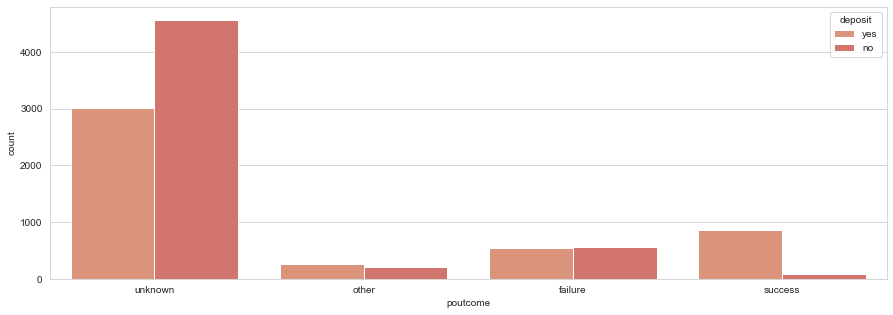

In [181]:
# Comparison of the outcomes of current campaign by the previous campaign
fig = plt.figure(figsize =(15, 5))
sns.countplot(x='poutcome',hue= 'deposit',  data=df)

Individuals for whom the previous campaign resulted in success, are more likely to make a deposit.

<AxesSubplot:xlabel='month', ylabel='count'>

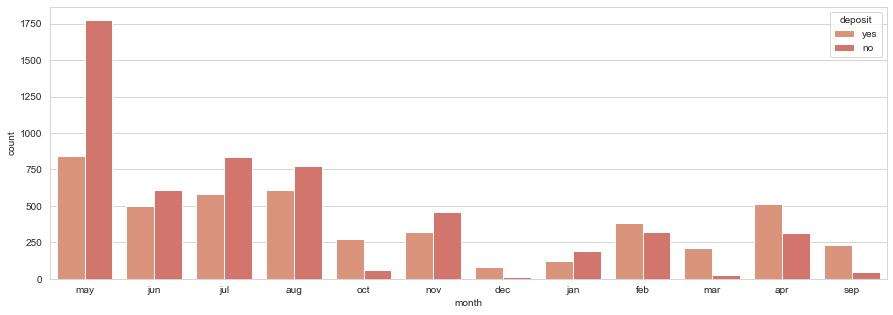

In [182]:
# Comparison of the outcomes of current campaign by month
fig = plt.figure(figsize =(15, 5))
sns.countplot(x='month',hue= 'deposit',  data=df)

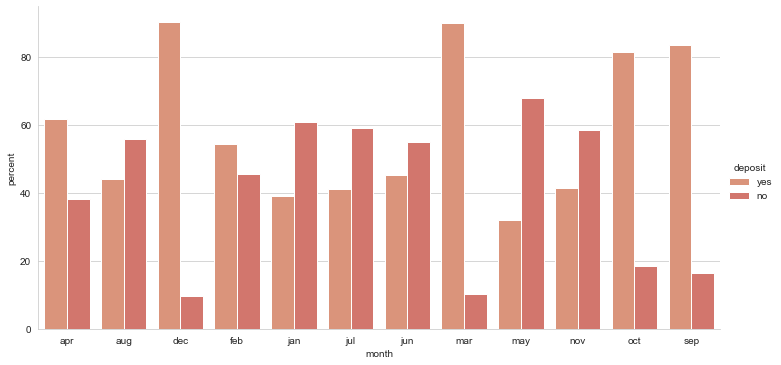

In [183]:
plot_df  = df.groupby('month')['deposit'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
sns.catplot(x='month', y = 'percent', hue= 'deposit',  data=plot_df, kind = 'bar', height=5, aspect=2)


May seems to be a bad month for the campaign, while December, March, October and September are particularly good.

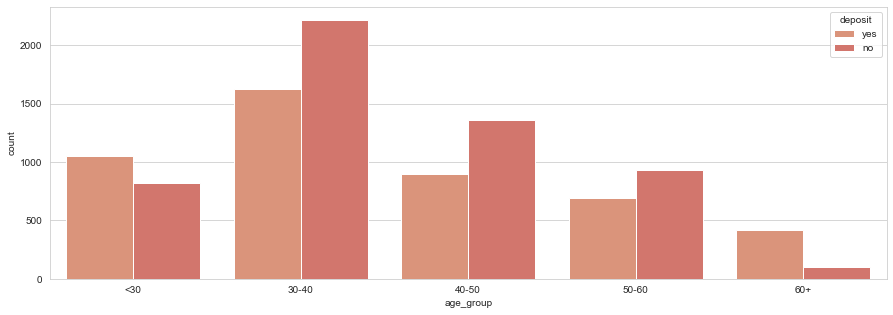

In [184]:
# Comparison of the outcomes of current campaign by age groups
bins = [0, 30,40,50, 60, 200]
df['age_group'] = pd.cut(df['age'], bins, labels = ['<30','30-40', '40-50', '50-60', '60+']) # create age groups
fig = plt.figure(figsize =(15, 5))
sns.countplot(x='age_group',hue= 'deposit',  data=df)
df.drop(columns= ['age'], inplace= True)

individuals in age groups '<30' and '60+' are more likely to open deposit. 


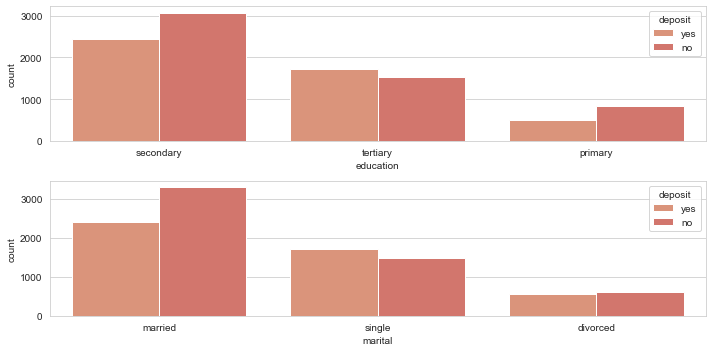

In [185]:
# Comparison of the outcomes of current campaign by marital status and education

fig ,ax = plt.subplots(2, 1, figsize =(10,5) )
sns.countplot(x='education', data=df, hue= 'deposit', ax=ax[0])
sns.countplot(x='marital', data=df, hue= 'deposit', ax=ax[1])
plt.tight_layout()

Single people with and individuals with tertiary education are more likely to open a deposit.

<AxesSubplot:xlabel='job', ylabel='count'>

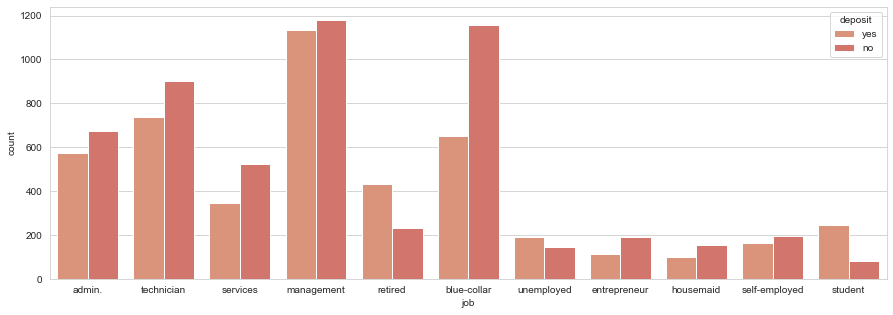

In [186]:
# Comparison of the outcomes of current campaign by occupation
fig = plt.figure(figsize =(15, 5))
sns.countplot(x='job', data=df, hue = 'deposit')

<AxesSubplot:xlabel='marital', ylabel='education'>

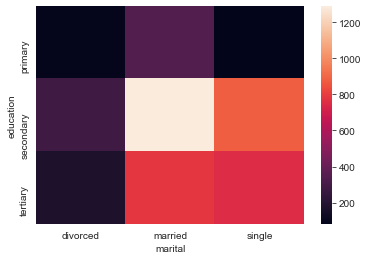

In [187]:
pivot_df = pd.pivot_table(df[df['deposit']=='yes'], values= 'deposit', index = 'education', columns= 'marital', aggfunc= 'count') 
sns.heatmap(pivot_df)

# Feature selection

Variables transformation: 
- ordinal encoding of *education* and *age groups*
- binary encoding of *deposit*, 
- one hot encoding of *job*, *marital*, *contact*, *month*, *poutcome*

In [188]:
# Ordinal encoding
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
print(le.classes_)

oe = OrdinalEncoder(categories=[[ '<30', '30-40','40-50', '50-60', '60+']])
df['age_group'] = oe.fit_transform(df[['age_group']])
print(oe.categories_)

# Encoding into dummies
lb = LabelBinarizer()
df['deposit'] = lb.fit_transform(df['deposit'])
print(lb.classes_)

lb = LabelBinarizer()
df['default'] = lb.fit_transform(df['default'])
print(lb.classes_)

lb = LabelBinarizer()
df['housing'] = lb.fit_transform(df['housing'])
print(lb.classes_)

lb = LabelBinarizer()
df['loan'] = lb.fit_transform(df['loan'])
print(lb.classes_)

# One hot encoding
df = pd.concat([df, pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])], axis = 1)
df.drop(columns=['job', 'marital', 'contact', 'month', 'poutcome'], inplace=True)
df.shape

['primary' 'secondary' 'tertiary']
[array(['<30', '30-40', '40-50', '50-60', '60+'], dtype=object)]
['no' 'yes']
['no' 'yes']
['no' 'yes']
['no' 'yes']


(10105, 45)

## Correlation check

<AxesSubplot:>

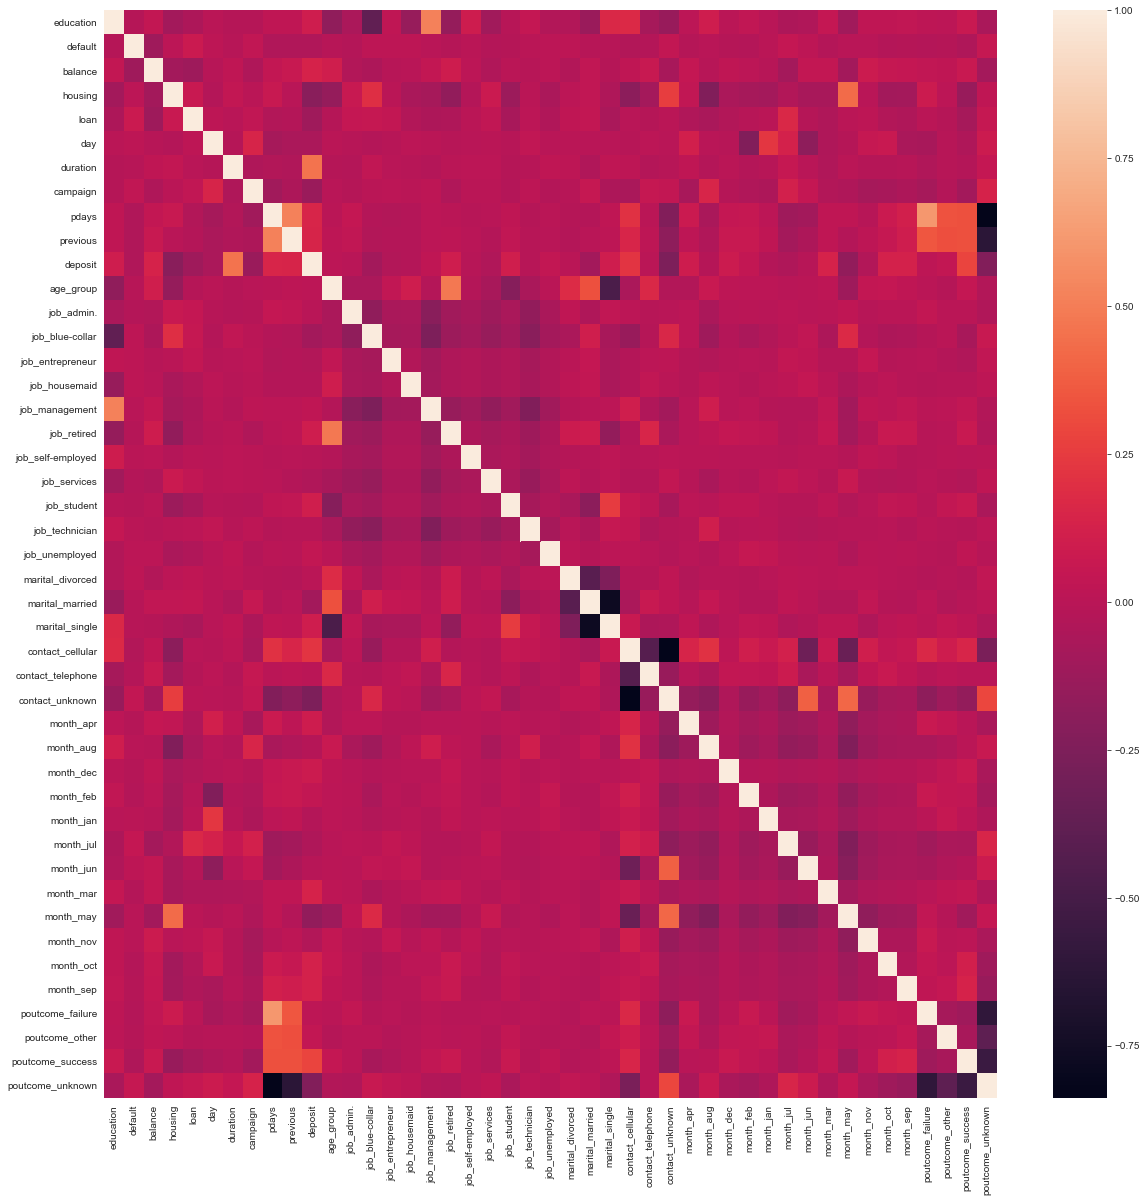

In [189]:
fig = plt.figure(figsize =(20, 20))
sns.heatmap(df.corr())

''

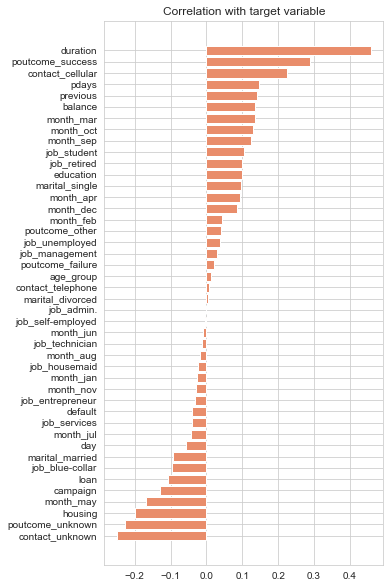

In [190]:
fig= plt.subplots(figsize=(5,10)) 
#y_corr = pd.DataFrame(df.corr()['deposit'][:]).abs()
y_corr = pd.DataFrame(df.corr()['deposit'][:])
y_corr = y_corr.sort_values(['deposit'])[:-1]
plt.barh(y_corr.index, y_corr['deposit'])
plt.title('Correlation with target variable')
;

## Test train split

In [191]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Shape of train sample: ', y_train.shape)
print('Shape of test sample: ', y_test.shape)

Shape of train sample:  (6770,)
Shape of test sample:  (3335,)


## Feature selection

In [192]:
# Select 20 best features
select_k_best_classifier = SelectKBest(score_func=f_classif, k=20).fit(X_train, y_train)
select_k_best_classifier.get_support()
feature_names = list(X_train.columns.values)
mask = select_k_best_classifier.get_support() #list of booleans
new_features = [] # The list of your K best features
 
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
new_features

['education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_blue-collar',
 'job_retired',
 'job_student',
 'contact_cellular',
 'contact_unknown',
 'month_apr',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [193]:
# Keep variables selected in task 6
X_test = X_test[new_features]
X_train = X_train[new_features]

## Data normalizing

In [194]:
# min max sxaler
mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

# Classification problem: Logistic Regression and Decision Tree

## Logistic Regression

In [195]:
lr = linear_model.LogisticRegression(max_iter=1000, 
                                     random_state= 42, 
                                     solver= 'sag')
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred = lr.predict(X_test_scaled)
print('Accuracy on train sample: ', round(metrics.accuracy_score(y_pred_train, y_train), 2))
print('Accuracy on test sample: ', round(metrics.accuracy_score(y_pred, y_test), 2))

print(metrics.classification_report(y_test, y_pred))

Accuracy on train sample:  0.83
Accuracy on test sample:  0.81
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1790
           1       0.82      0.75      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



## Decision Tree

In [196]:
dt = tree.DecisionTreeClassifier(criterion= 'entropy',
                                 random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred_train = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)
print('Accuracy on train sample: ', round(metrics.accuracy_score(y_pred_train, y_train), 2))
print('Accuracy on test sample: ', round(metrics.accuracy_score(y_pred, y_test), 2))

print(metrics.classification_report(y_test, y_pred))


Accuracy on train sample:  1.0
Accuracy on test sample:  0.75
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      1790
           1       0.73      0.72      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



The decision tree with default parameters performs worse than logistic regression. We need to tune the parameters for the decision tree. 

## Hyperparameter tuning

In [197]:
# Tuning maximum depth for decision tree
max_depth = np.linspace(1,20, 20, dtype=int) # range of max depth from 1 to 20

train_scores = []
test_scores = []

for md in max_depth:
    dt = tree.DecisionTreeClassifier(criterion= 'entropy',
                                     random_state=42,
                                     max_depth = md)
    dt.fit(X_train_scaled, y_train)
    y_pred_train = dt.predict(X_train_scaled)
    train_scores.append(metrics.accuracy_score( y_train, y_pred_train))
    y_pred = dt.predict(X_test_scaled)
    test_scores.append(metrics.accuracy_score(y_test, y_pred ))

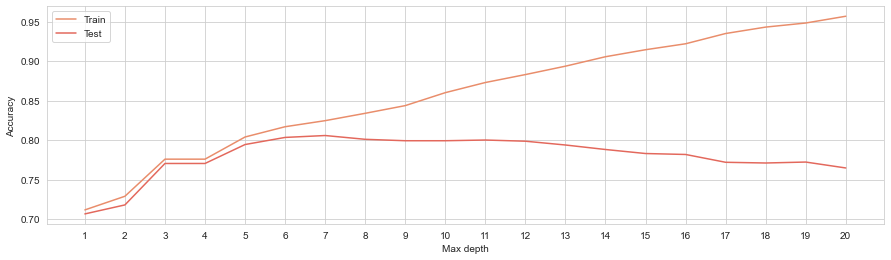

In [198]:
# Visualizytion of accuracy from maximum depth
fig, ax = plt.subplots(figsize=(15, 4)) 
ax.plot(max_depth, train_scores, label='Train') 
ax.plot(max_depth, test_scores, label='Test') 
ax.set_xlabel('Max depth')
ax.set_ylabel('Accuracy') 
ax.set_xticks(max_depth) 
#ax.xaxis.set_tick_params(rotation=45) 
ax.legend();

In [199]:
dt = tree.DecisionTreeClassifier(criterion= 'entropy',
                                 random_state=42, 
                                 max_depth=6)
dt.fit(X_train_scaled, y_train)
y_pred_train = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)
print('Accuracy on train sample: ', round(metrics.accuracy_score(y_pred_train, y_train), 2))
print('Accuracy on test sample: ', round(metrics.accuracy_score(y_pred, y_test), 2))

print(metrics.classification_report(y_test, y_pred))


Accuracy on train sample:  0.82
Accuracy on test sample:  0.8
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



The best score for test sample is at maximum depth 6; there is no overfitting at this value as well.

In [200]:
# Hyperparameter tuning using gridsearch
dt = tree.DecisionTreeClassifier(criterion= 'entropy',
                                 random_state=42)
params = {'min_samples_split' : [2, 5, 7, 10],
          'max_depth' : [3,5,7]}
grid_search = GridSearchCV(estimator = dt, 
                           param_grid= params)
grid_search.fit(X_train_scaled, y_train)

y_pred = grid_search.predict(X_test_scaled)

print('Accuracy on train sample: ', round(metrics.accuracy_score(y_pred_train, y_train), 2))
print('Accuracy on test sample: ', round(metrics.accuracy_score(y_pred, y_test), 2))

print(metrics.classification_report(y_test, y_pred))

Accuracy on train sample:  0.82
Accuracy on test sample:  0.81
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1790
           1       0.81      0.77      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.81      0.80      3335



Model with grid search for two parameters is slighly better than with tuning only maximum depth.

# Ensemble methods

## Random Forest

In [201]:
rf = ensemble.RandomForestClassifier(n_estimators = 100,
                                    criterion = 'gini',
                                    min_samples_leaf = 5,
                                    max_depth = 10,
                                    random_state = 42)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



## XGBoost

In [202]:
xgb = GradientBoostingClassifier(learning_rate = 0.05,
                                n_estimators = 300,
                                min_samples_leaf = 5,
                                max_depth = 5,
                                random_state = 42)

xgb.fit(X_train_scaled, y_train)
y_pred = xgb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1790
           1       0.81      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



<BarContainer object of 20 artists>

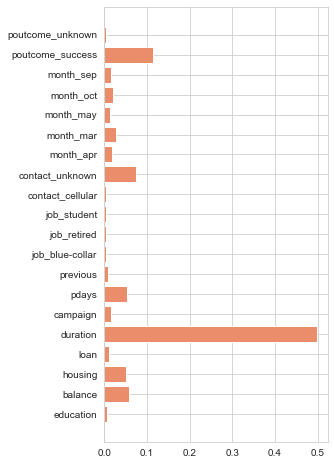

In [203]:
# Best predictors in XGBoost
fig, ax = plt.subplots(figsize=(4, 8)) 
ax.barh(X_train.columns, xgb.feature_importances_)

## Stacking model

In [204]:
estimators = [('dt', grid_search.best_estimator_),
                ('lr', lr)]
stack = StackingClassifier(estimators = estimators,
                           final_estimator= GradientBoostingClassifier(learning_rate = 0.05,
                                n_estimators = 300,
                                min_samples_leaf = 5,
                                max_depth = 5,
                                random_state = 42)
)
stack.fit(X_train_scaled, y_train)

y_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



## Hyperparameter optimization with Optuna


In [205]:
def optuna_rf(trial):
  # set the parameter space
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # create model
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # train model
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))
 
  return score
  

In [206]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# search best params
study.optimize(optuna_rf, n_trials=20)
print("Best parameters {}".format(study.best_params))

[I 2022-05-29 14:39:52,990] A new study created in memory with name: RandomForestClassifier
[I 2022-05-29 14:39:54,225] Trial 0 finished with value: 0.8760304868564317 and parameters: {'n_estimators': 175, 'max_depth': 19, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8760304868564317.
[I 2022-05-29 14:39:55,421] Trial 1 finished with value: 0.8583476495392786 and parameters: {'n_estimators': 174, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8760304868564317.
[I 2022-05-29 14:39:56,642] Trial 2 finished with value: 0.9132549019607844 and parameters: {'n_estimators': 146, 'max_depth': 20, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9132549019607844.
[I 2022-05-29 14:39:57,512] Trial 3 finished with value: 0.8793398723338004 and parameters: {'n_estimators': 118, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9132549019607844.
[I 2022-05-29 14:39:58,648] Trial 4 finished with value: 0.863131550132958 and parameters: {'n_e

Best parameters {'n_estimators': 100, 'max_depth': 25, 'min_samples_leaf': 2}


In [207]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42 )
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

